# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import time
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:
## Specify appropriate transforms, and batch_sizes
train_dir = 'landmark_images/train'
test_dir = 'landmark_images/test'

batch_size = 50
valid_size = 0.2

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalization = transforms.Normalize(mean=mean, std=std)

data_transforms = {
  'augment': transforms.Compose([transforms.RandomRotation(30),
                              transforms.RandomResizedCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              normalization,]),
  'no_augment' : transforms.Compose([transforms.Resize(224),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              normalization,])
}

image_datasets = {
  'train': datasets.ImageFolder(train_dir, transform=data_transforms['augment']),
  'valid': datasets.ImageFolder(train_dir, transform=data_transforms['no_augment']),
  'test' : datasets.ImageFolder(test_dir, transform=data_transforms['no_augment'])
}

num_train = len(image_datasets['train'])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

label_mapping = image_datasets['train'].classes
label_mapping = list(map(lambda x: x.split('.')[1].replace('_', ' '), label_mapping))
print(len(label_mapping), 'classes in this dataset')
print(label_mapping)

50 classes in this dataset
['Haleakala National Park', 'Mount Rainier National Park', 'Ljubljana Castle', 'Dead Sea', 'Wroclaws Dwarves', 'London Olympic Stadium', 'Niagara Falls', 'Stonehenge', 'Grand Canyon', 'Golden Gate Bridge', 'Edinburgh Castle', 'Mount Rushmore National Memorial', 'Kantanagar Temple', 'Yellowstone National Park', 'Terminal Tower', 'Central Park', 'Eiffel Tower', 'Changdeokgung', 'Delicate Arch', 'Vienna City Hall', 'Matterhorn', 'Taj Mahal', 'Moscow Raceway', 'Externsteine', 'Soreq Cave', 'Banff National Park', 'Pont du Gard', 'Seattle Japanese Garden', 'Sydney Harbour Bridge', 'Petronas Towers', 'Brooklyn Bridge', 'Washington Monument', 'Hanging Temple', 'Sydney Opera House', 'Great Barrier Reef', 'Monumento a la Revolucion', 'Badlands National Park', 'Atomium', 'Forth Bridge', 'Gateway of India', 'Stockholm City Hall', 'Machu Picchu', 'Death Valley National Park', 'Gullfoss Falls', 'Trevi Fountain', 'Temple of Heaven', 'Great Wall of China', 'Prague Astronomic

In [31]:
loaders_scratch = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, sampler=valid_sampler),
    'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True),
}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

I decided to resize all the input images to 224x224 in anticipation of processing them with a VGG model, which means I also normalized the images to be compatible the the VGG model as well, according to the [documentation](https://pytorch.org/hub/pytorch_vision_vgg/)

For data augmentation I chose to use RandomRotation, RandomResizedCrop, RandomHorizontalFlip to prevent over-fitting

I created a validation dataset out of 20% of the train dataset, with no data augmentation applied to the validation or test set

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Class: Taj Mahal, Shape: torch.Size([3, 224, 224])
Class: Atomium, Shape: torch.Size([3, 224, 224])
Class: Forth Bridge, Shape: torch.Size([3, 224, 224])
Class: Changdeokgung, Shape: torch.Size([3, 224, 224])
Class: Dead Sea, Shape: torch.Size([3, 224, 224])


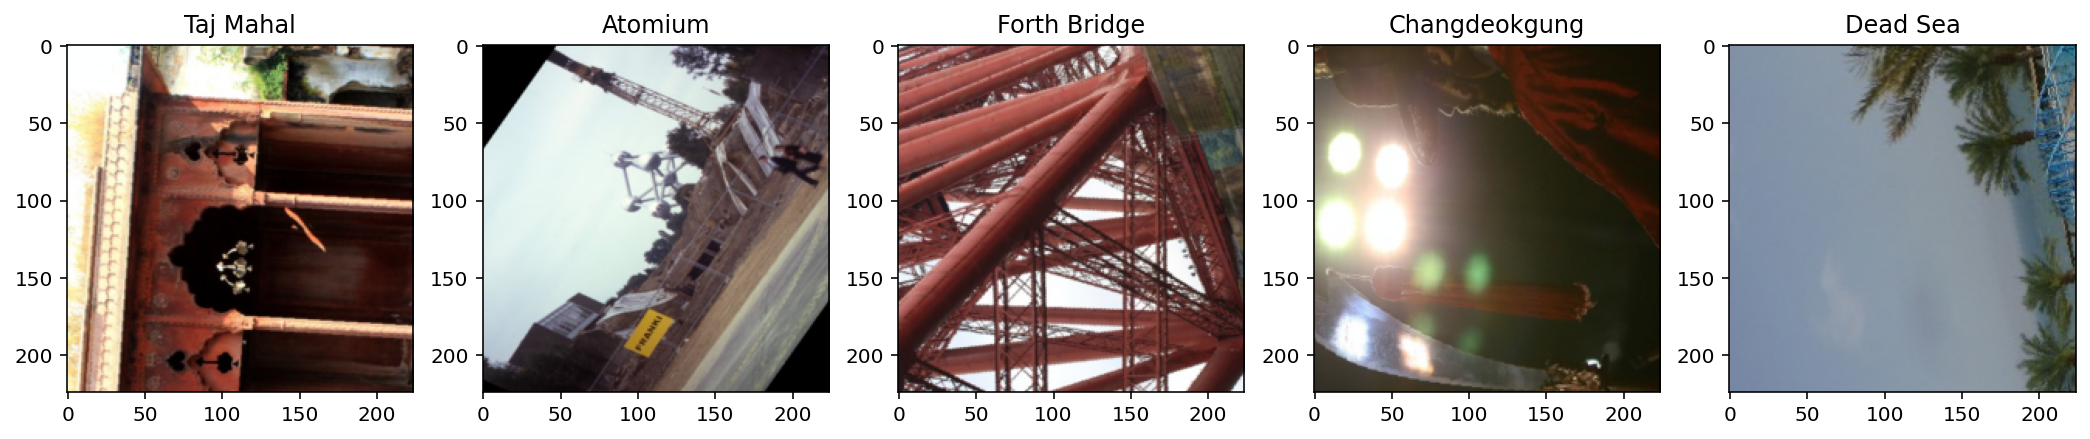

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

def show5(dataloader, label_mapping):
    dataiter = iter(dataloader)
    fig, ax = plt.subplots(figsize=(18, 10), ncols=5)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        title = label_mapping[labels[i].item()]
        print(f'Class: {title}, Shape: {images[i].shape}')
    
        image = images[i].numpy().T
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax[i].set_title(title)
        ax[i].imshow(image)


show5(loaders_scratch['train'], label_mapping)


### Initialize use_cuda variable

In [32]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda:0


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [33]:
criterion_scratch = nn.NLLLoss()

def get_optimizer_scratch(model):
    return optim.Adam(model.parameters()) 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [34]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # sees 224x224x3 tesnsor
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        # sees 112x112x16 tensor
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        # sees 56x56x32 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        # sees 28x28x64 tensor
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)
        # outputs 14x14x64 tensor
        # expects flattened tensor with 12544 features
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(12544, 500)),
            ('fc1_bn', nn.BatchNorm1d(500)),
            ('relu1', nn.ReLU()),
            ('dropout1', nn.Dropout(p=0.2)),
            ('fc2', nn.Linear(500, 250)),
            ('relu2', nn.ReLU()),
            ('fc2_bn', nn.BatchNorm1d(250)),
            ('dropout2', nn.Dropout(p=0.2)),
            ('fc3', nn.Linear(250, 100)),
            ('fc3_bn', nn.BatchNorm1d(100)),
            ('relu3', nn.ReLU()),
            ('dropout3', nn.Dropout(p=0.2)),
            ('fc_final', nn.Linear(100, 50)),
            ('fc_final_bn', nn.BatchNorm1d(50)),
            ('log_output', nn.LogSoftmax(dim=1))
        ]))
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = F.max_pool2d(x,2)
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = F.max_pool2d(x,2)
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = F.max_pool2d(x,2)
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = F.max_pool2d(x,2)
        
        x = x.view(-1, 14 * 14 * 64)
        x = self.classifier(x)
        
        self.log_ps = x
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
I created 4 convolutional layers each with a max pooling layer so that each successive convolutional layer would be half the dimensions of the previous layer. I chose to double the number of feature maps at each convolutional layer, expecting that each successive layer would extract more numerous and higher level features from the layer below. I also used batch normalization at each layer for faster convergence

Finally I flattened the last convolutional layer and used it as input to a multilayer perceptron classifier with 4 hidden layers, the last of which has an out feature for each of the 50 classes.

Because I am using NLLLoss as the criterion I did a log_softmax on the output of the final layer. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [35]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            log_ps = model.forward(data)
            loss = criterion(log_ps, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                log_ps = model.forward(data)
                loss = criterion(log_ps, target)
                valid_loss += loss.item()            

        train_loss = train_loss/len(loaders['train'])
        valid_loss = valid_loss/len(loaders['valid'])
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        if valid_loss < valid_loss_min:
            print('Validation loss has decreased, Saving...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [63]:
def custom_weight_init(m):
    if isinstance(m, nn.Linear):
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.970365 	Validation Loss: 3.627739
Validation loss has decreased, Saving...
Epoch: 2 	Training Loss: 3.612818 	Validation Loss: 3.396392
Validation loss has decreased, Saving...
Epoch: 3 	Training Loss: 3.464653 	Validation Loss: 3.315185
Validation loss has decreased, Saving...
Epoch: 4 	Training Loss: 3.361863 	Validation Loss: 3.227561
Validation loss has decreased, Saving...
Epoch: 5 	Training Loss: 3.294501 	Validation Loss: 3.083616
Validation loss has decreased, Saving...
Epoch: 6 	Training Loss: 3.223125 	Validation Loss: 3.007874
Validation loss has decreased, Saving...
Epoch: 7 	Training Loss: 3.178231 	Validation Loss: 2.994852
Validation loss has decreased, Saving...
Epoch: 8 	Training Loss: 3.103385 	Validation Loss: 2.855192
Validation loss has decreased, Saving...
Epoch: 9 	Training Loss: 3.060987 	Validation Loss: 2.806886
Validation loss has decreased, Saving...
Epoch: 10 	Training Loss: 3.009845 	Validation Loss: 2.744170
Validation loss has 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [37]:
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.927531 	Validation Loss: 3.599162
Validation loss has decreased, Saving...
Epoch: 2 	Training Loss: 3.634094 	Validation Loss: 3.371028
Validation loss has decreased, Saving...
Epoch: 3 	Training Loss: 3.503111 	Validation Loss: 3.307376
Validation loss has decreased, Saving...
Epoch: 4 	Training Loss: 3.436328 	Validation Loss: 3.198148
Validation loss has decreased, Saving...
Epoch: 5 	Training Loss: 3.321801 	Validation Loss: 3.135664
Validation loss has decreased, Saving...
Epoch: 6 	Training Loss: 3.256289 	Validation Loss: 3.169215
Epoch: 7 	Training Loss: 3.213811 	Validation Loss: 3.045684
Validation loss has decreased, Saving...
Epoch: 8 	Training Loss: 3.154529 	Validation Loss: 2.949056
Validation loss has decreased, Saving...
Epoch: 9 	Training Loss: 3.104665 	Validation Loss: 2.875825
Validation loss has decreased, Saving...
Epoch: 10 	Training Loss: 3.045764 	Validation Loss: 2.797895
Validation loss has decreased, Saving...
Epoch: 11 	Training 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [39]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for data, target in loaders['test']:
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model.forward(data)
            ps = torch.exp(log_ps)
            # calculate the loss
            loss = criterion(log_ps, target)
            # update average test loss 
            test_loss += loss.item()
            # convert output probabilities to predicted class
            top_p, top_class = ps.topk(1, dim=1)
            # compare predictions to true label
            correct += torch.sum((top_class == target.reshape(*top_class.shape)).type(torch.FloatTensor)).item()
            total += data.size(0)

    
    test_loss = test_loss/len(loaders['test'])
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [40]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.482065


Test Accuracy: 35% (441/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [6]:
loaders_transfer = {
  'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler),
  'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, sampler=valid_sampler),
  'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True),
}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [7]:
criterion_transfer = nn.NLLLoss()

def get_optimizer_transfer(model):
    return optim.Adam(model.parameters())    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [8]:
model_transfer = torchvision.models.vgg16(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False

print('model\'s classifier expects', model_transfer.classifier[0].in_features, 'in_features')

model_transfer.classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(25088, 5000)),
                ('relu1', nn.ReLU()),
                ('dropout1', nn.Dropout(p=0.2)),
                ('fc2', nn.Linear(5000, 1000)),
                ('relu2', nn.ReLU()),
                ('dropout2', nn.Dropout(p=0.2)),
                ('fc3', nn.Linear(1000, 500)),
                ('relu3', nn.ReLU()),
                ('dropout3', nn.Dropout(p=0.2)),
                ('fc4', nn.Linear(500, 100)),
                ('relu4', nn.ReLU()),
                ('dropout4', nn.Dropout(p=0.2)),
                ('fc_final', nn.Linear(100, 50)),
                ('log_output', nn.LogSoftmax(dim=1))
            ]))

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

model's classifier expects 25088 in_features


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I decided to use a pre-trained VGG16 model to do transfer learning of lower level features in the landmark images. Because the VGG16 model was pre-trained on the imagenet dataset I figure that it will do a good job of extracting lower level features from the landmark images as they are similar in composition. I belive they are so similar that fine-tuning will not be needed and I will be freezing the convolutional layers from training.

After freezing the convolutional layers of the model, I replaced the classifier with a multilayered preceptron with four hidden layers. the classifier has an out feature for each of the 50 landmark classes

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            log_ps = model.forward(data)
            loss = criterion(log_ps, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()          

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                log_ps = model.forward(data)
                loss = criterion(log_ps, target)
                valid_loss += loss.item()            

        train_loss = train_loss/len(loaders['train'])
        valid_loss = valid_loss/len(loaders['valid'])

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        if valid_loss < valid_loss_min:
            print('Validation loss has decreased, Saving...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        
    return model

In [10]:
num_epochs = 50
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.533664 	Validation Loss: 2.642859
Validation loss has decreased, Saving...
Epoch: 2 	Training Loss: 2.607214 	Validation Loss: 2.003119
Validation loss has decreased, Saving...
Epoch: 3 	Training Loss: 2.192942 	Validation Loss: 1.752808
Validation loss has decreased, Saving...
Epoch: 4 	Training Loss: 1.899489 	Validation Loss: 1.535602
Validation loss has decreased, Saving...
Epoch: 5 	Training Loss: 1.804862 	Validation Loss: 1.514093
Validation loss has decreased, Saving...
Epoch: 6 	Training Loss: 1.677722 	Validation Loss: 1.423889
Validation loss has decreased, Saving...
Epoch: 7 	Training Loss: 1.587981 	Validation Loss: 1.372362
Validation loss has decreased, Saving...
Epoch: 8 	Training Loss: 1.480013 	Validation Loss: 1.373582
Epoch: 9 	Training Loss: 1.411466 	Validation Loss: 1.284875
Validation loss has decreased, Saving...
Epoch: 10 	Training Loss: 1.398468 	Validation Loss: 1.249422
Validation loss has decreased, Saving...
Epoch: 11 	Training 

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [11]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.066979


Test Accuracy: 74% (934/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [12]:
import cv2
from PIL import Image

def predict_landmarks(img_path, k):
    resized_image = Image.open(img_path)
    probs, labels = None, None

    if resized_image.size[1] < resized_image.size[0]:
        resized_image.thumbnail((255, math.pow(255, 2)))
    else:
        resized_image.thumbnail((math.pow(255, 2), 255))

    # Crop the image
    left = (resized_image.width-224)/2
    bottom = (resized_image.height-224)/2
    right = left + 224
    top = bottom + 224
    resized_image = resized_image.crop((left, bottom, right, top))
    
    # normalize the image
    np_image = np.array(resized_image)/255
    np_image = (np_image - mean)/std
    np_image = np.transpose(np_image, (2,0,1))

    tensor_image = torch.FloatTensor([np_image]).cuda()
    model_transfer.eval()
    with torch.no_grad():
        probs, idxs = model_transfer.forward(tensor_image).topk(k)
        probs = torch.exp(probs.data).cpu().numpy().squeeze()
        labels = list(map(lambda x: label_mapping[x], idxs.data.cpu().numpy().squeeze()))

    # labels = list(map(lambda x: x.split('.')[1].replace('_', ' '), labels))
    return (labels, probs, resized_image)

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

/home/dylan/.pyenv/versions/3.7.10/envs/kitchen_sink/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


(['Golden Gate Bridge',
  'Brooklyn Bridge',
  'Sydney Harbour Bridge',
  'Forth Bridge',
  'Sydney Opera House'],
 array([9.1554105e-01, 8.4340326e-02, 1.0128359e-04, 7.1542831e-06,
        6.5357976e-06], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224 at 0x7F1410C78410>)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

-----
Is this a picture of Golden Gate Bridge, Brooklyn Bridge, or Sydney Harbour Bridge?


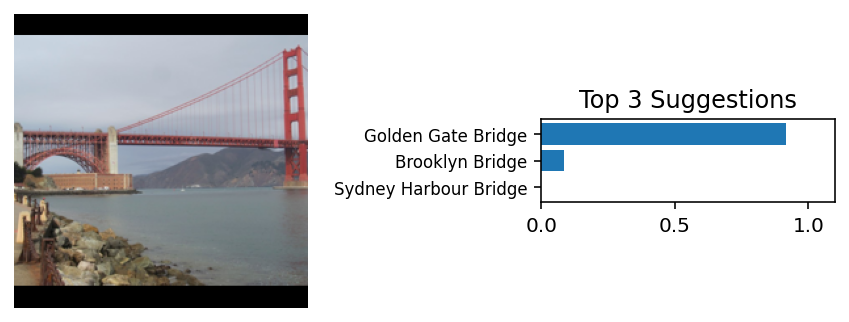

In [13]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks, probabilities, image = predict_landmarks(img_path, 3)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')
    ax2.barh(np.arange(3), probabilities[::-1])
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(3))
    ax2.set_yticklabels(predicted_landmarks[::-1], size='small');
    ax2.set_title('Top 3 Suggestions')
    ax2.set_xlim(0, 1.1)
    text_prediction = f"-----\nIs this a picture of {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?"
    plt.tight_layout()
    print(text_prediction)
    plt.show()

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
My model worked quite well with 76% accuracy on the test set.
Some possible ways to imporve the model, however are:
- training on a larger dataset with more and varied perspectives on various landmarks
- experimenting with different pretrained models for transfer learning; my model uses VGG but maybe another base architecture would perform better (e.g. Resnet, Alexnet, etc.)
- not freezing the layers from the pretrained model and allowing the training to fine tune the earlier layers

-----
Is this a picture of Atomium, Niagara Falls, or Central Park?


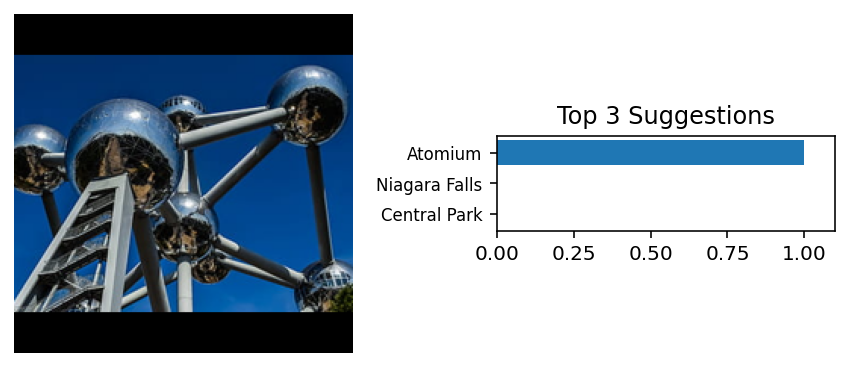

-----
Is this a picture of Eiffel Tower, Changdeokgung, or Atomium?


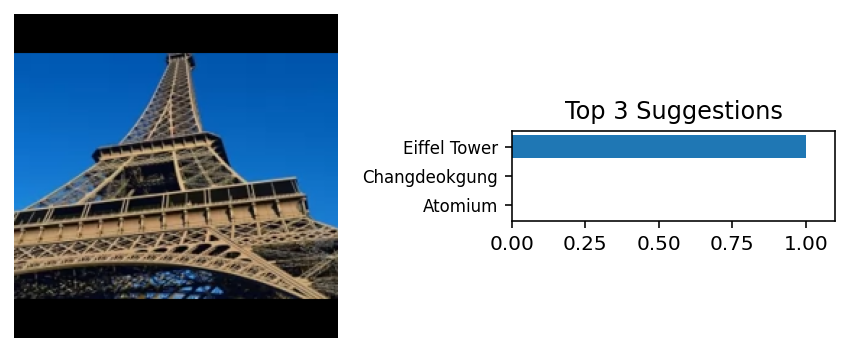

-----
Is this a picture of Machu Picchu, Haleakala National Park, or Great Wall of China?


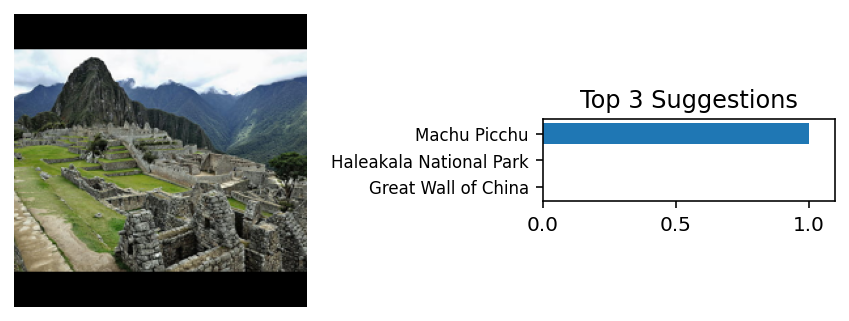

-----
Is this a picture of Soreq Cave, Hanging Temple, or Edinburgh Castle?


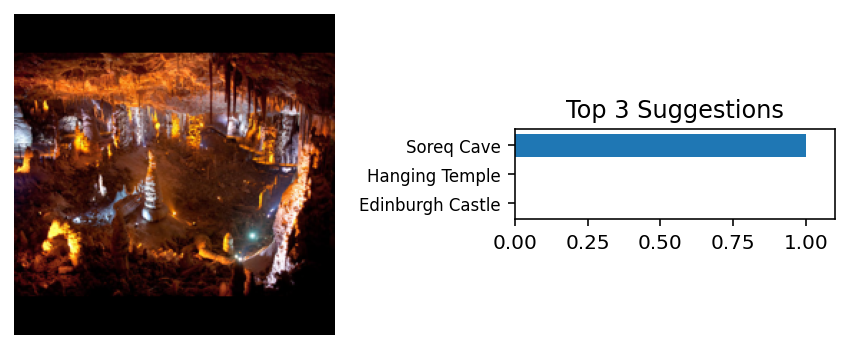

In [44]:
suggest_locations('original_internet_images/atomium.jpeg')
suggest_locations('original_internet_images/Eiffel_Tower_Ground_View.webp')
suggest_locations('original_internet_images/machu_picchu.jpeg')
suggest_locations('original_internet_images/soreq_cave.jpeg')

## Running TSNE on extracted features of image subset

Below I ran TSNE on the activations of the second to last layer to see if the patterns of activations would form distinct clusters around landmarks.
The result is that Clusters did form! However, some images near the middle of the scatter plot don't fall into a distinct cluster. I think that these images are harder to classify either beccause the main landmark isn't promenent in the image, the landmark is at an unusual perspective in the image, or the landmarl looks similar to another landmark

In [15]:
#add hook to intercept layer activations right before final layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_transfer.classifier.relu4.register_forward_hook(get_activation('relu4'))

In [16]:
# process all test images into vectors of extracted freatures from CNN
all_activations = []
all_labels = []

model_transfer.eval()
with torch.no_grad():
    for data, targets in loaders_transfer['test']:
        all_labels.extend(targets)
        model_transfer.forward(data.cuda())
        all_activations.extend(activation['relu4'].cpu().numpy())

all_activations = np.array(all_activations)
all_labels = np.array(all_labels)

print(all_activations.shape)
print(all_labels.shape)

(1250, 100)
(1250,)


In [ ]:
# run tsne with 2 components
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(all_activations).T

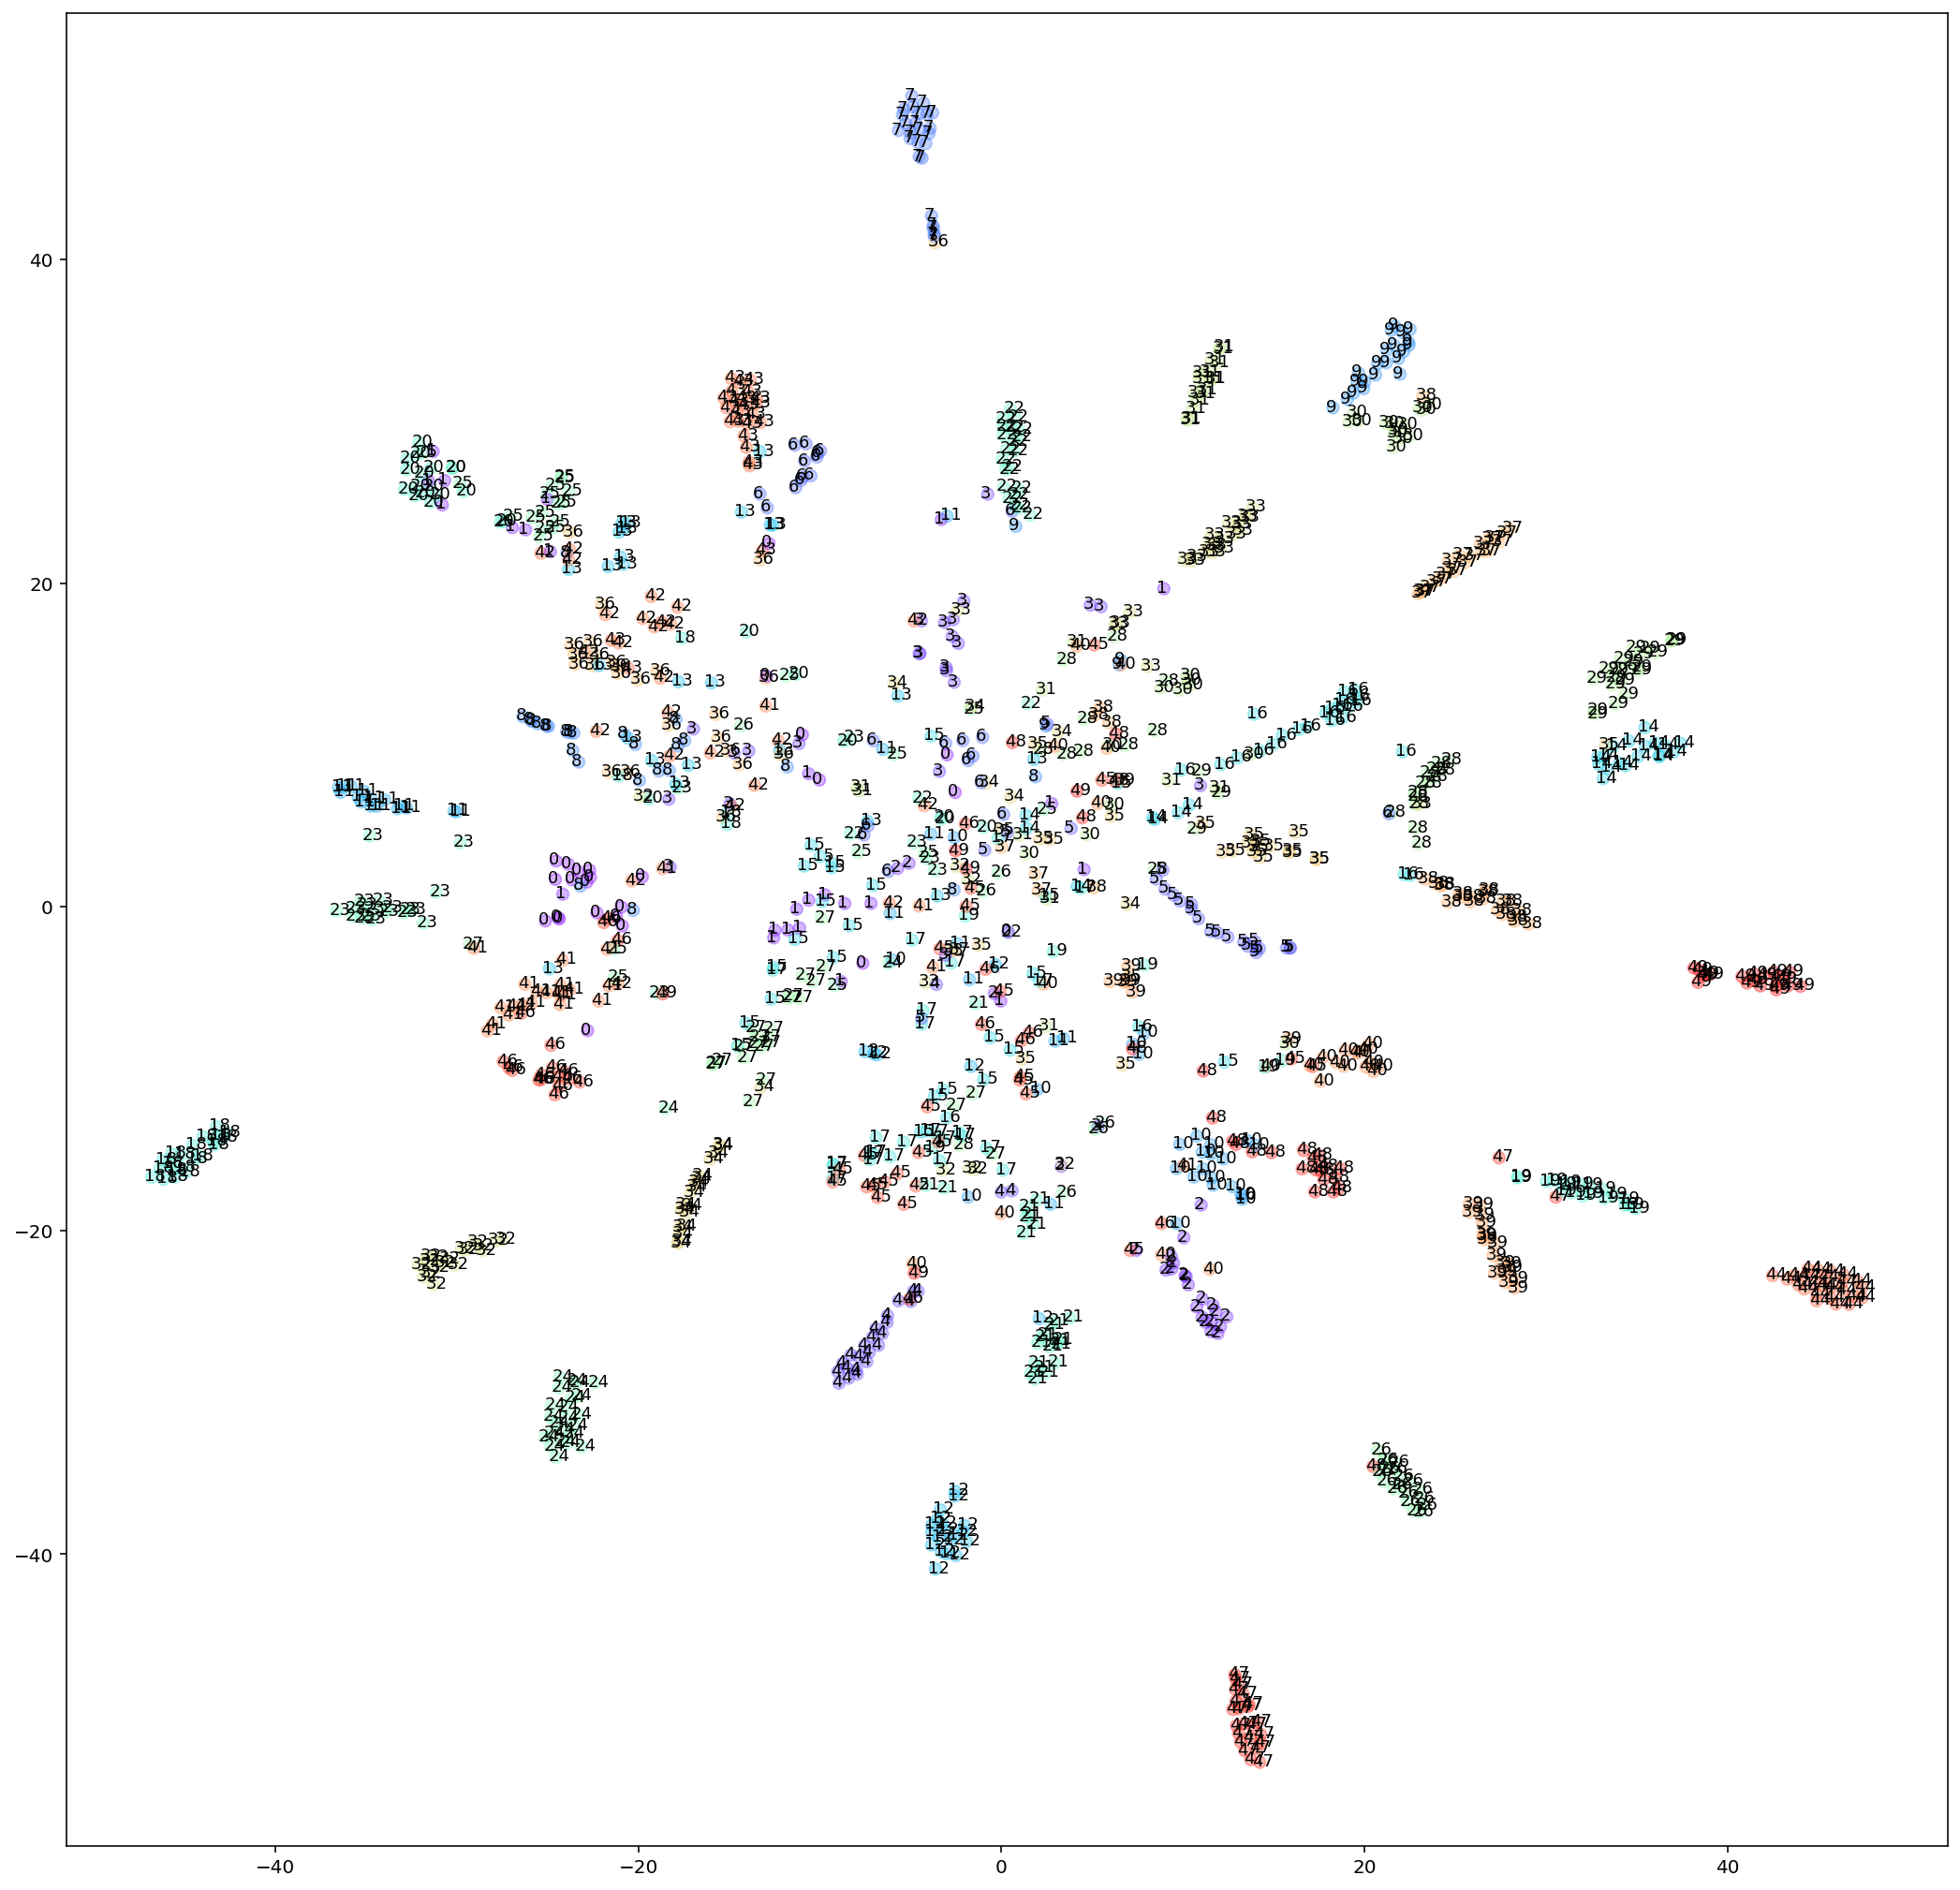

In [28]:
# examine clusters 
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot()
scatter = ax.scatter(transformed[0], transformed[1], s=40, c=all_labels, cmap='rainbow', alpha=0.3)

for x, y, l in zip(transformed[0], transformed[1], all_labels):
  ax.text(x-0.4, y-0.2, l, fontsize=9)

plt.show()